Show data. The objective is to show all te colums and whit type are they.

In [3]:
import pandas as pd
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.info()) #Mirar que columnas son objetos (texto) y cuáles números
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Show if 'Churn' colum is equilibrated

In [2]:
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


## Categoric Variables: CountPlot
We are going to show relasionship betwen some column tan could be corelate with the variable that we want to predict.
Lets start whit 'Contract' and 'Churn'

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_relationship(df, feature, target):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue=target, data=df, palette='viridis')
    plt.title(f'Relationship between {feature} and {target}')
    plt.show()

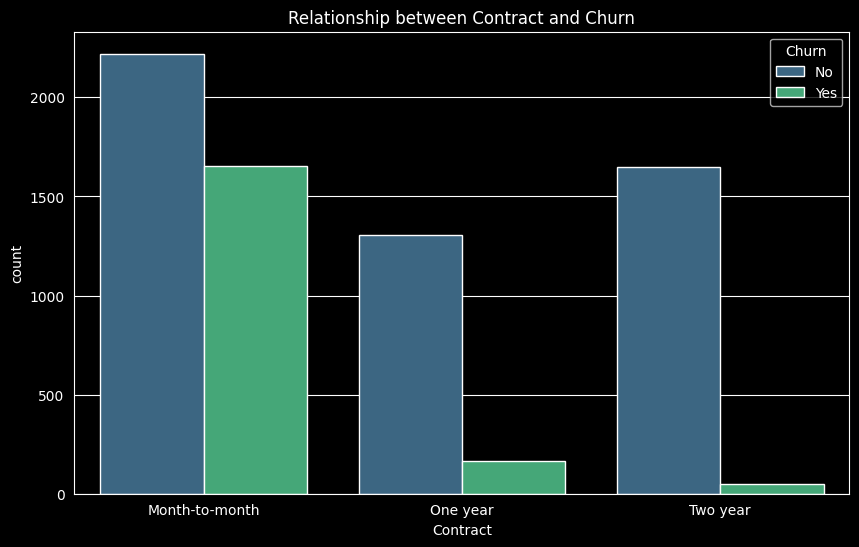

In [4]:
plot_categorical_relationship(df, 'Contract', 'Churn')

If we check the pay method

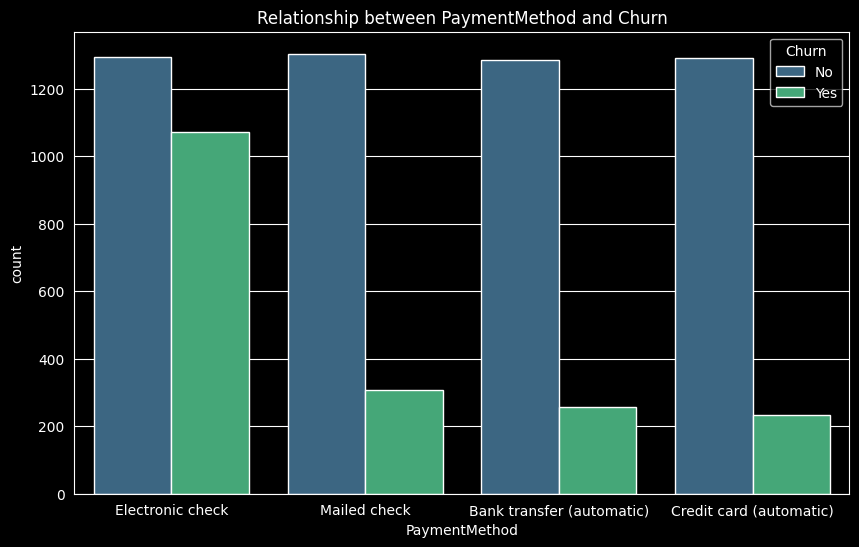

In [7]:
plot_categorical_relationship(df, 'PaymentMethod', 'Churn')

But, what apend if we check the gender?

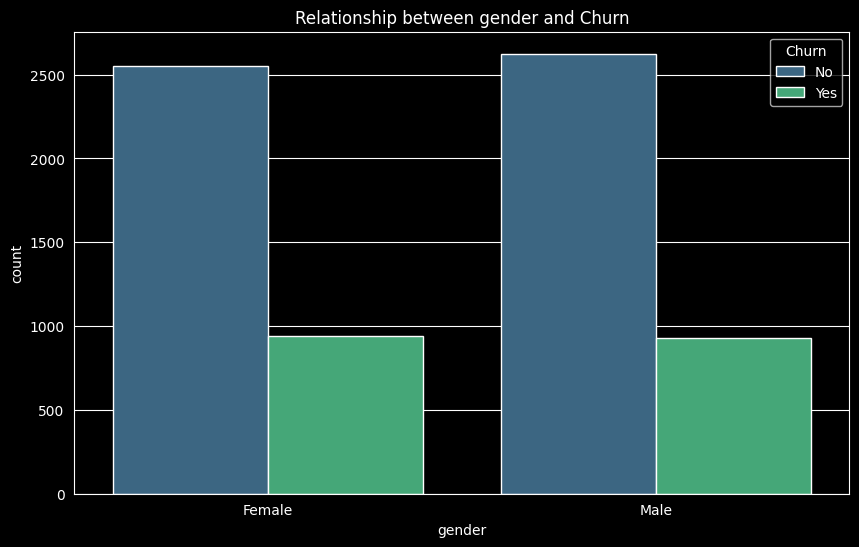

In [9]:
plot_categorical_relationship(df, 'gender', 'Churn')

As we can see, this is not relevant for our study. This colum is a good candidate to eliminate it.

## For numeric variables: BoxPlot
This is the best form to see how numeric variables evolves

In [10]:
def plot_numerical_relationship(df, feature, target):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=feature, data=df, palette='magma')
    plt.title(f'Distribution of {feature} by {target}')
    plt.show()

/tmp/ipykernel_20655/3990837831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='magma')


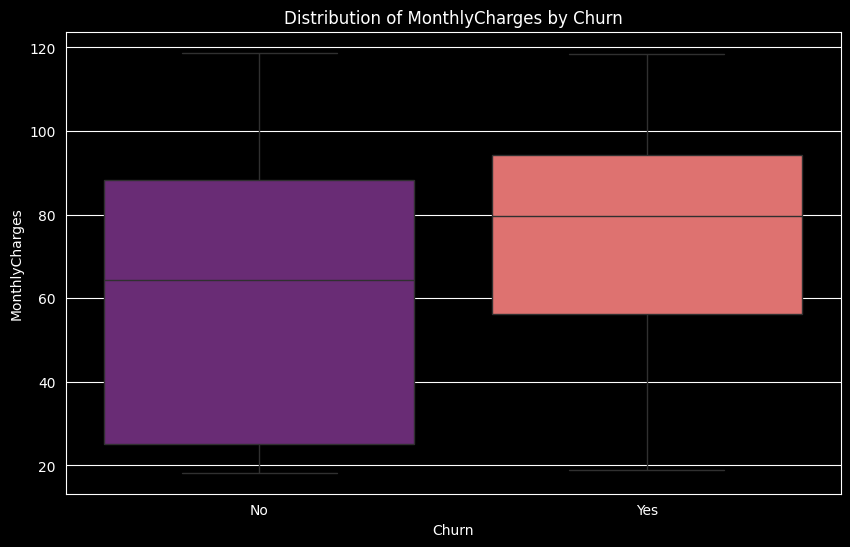

In [11]:
plot_numerical_relationship(df, 'MonthlyCharges', 'Churn')

/tmp/ipykernel_20655/3990837831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='magma')


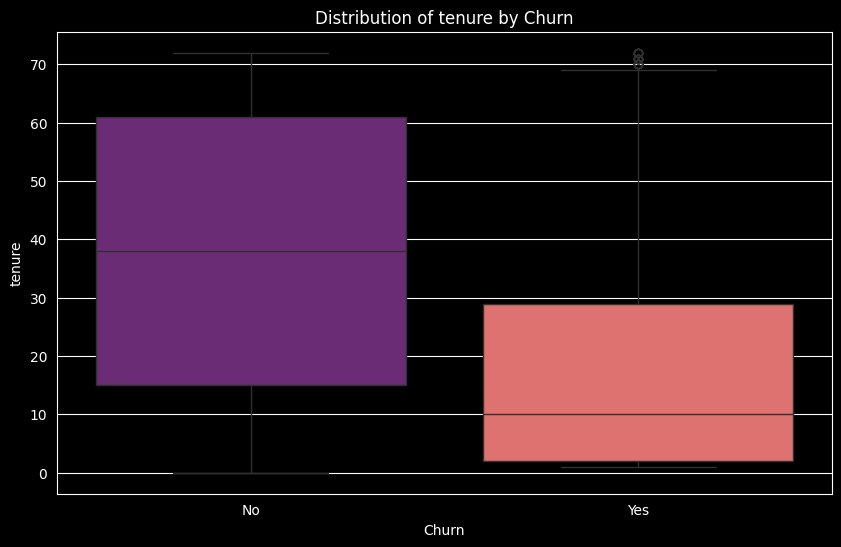

In [14]:
plot_numerical_relationship(df, 'tenure', 'Churn')

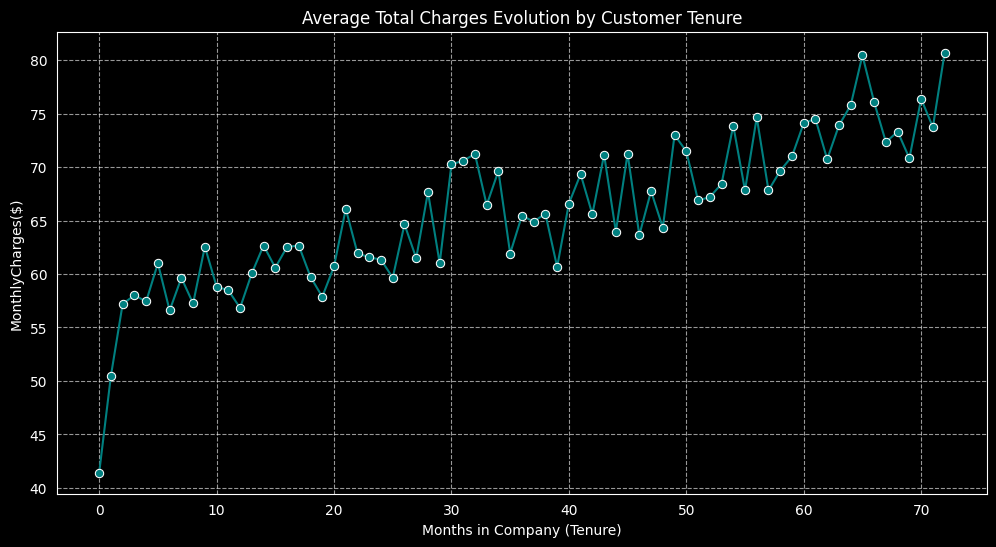

In [23]:
def plot_price_evolution(df):
    # Agrupamos
    evolution = df.groupby('tenure')['MonthlyCharges'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    # Cambiado MonthlyCharges por TotalCharges para que coincida con el agrupamiento
    sns.lineplot(data=evolution, x='tenure', y='MonthlyCharges', marker='o', color='teal')

    plt.title('Average Total Charges Evolution by Customer Tenure')
    plt.xlabel('Months in Company (Tenure)')
    plt.ylabel('MonthlyCharges($)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_price_evolution(df)


## HeatMap
This shows wich columns have more numeric weight over others

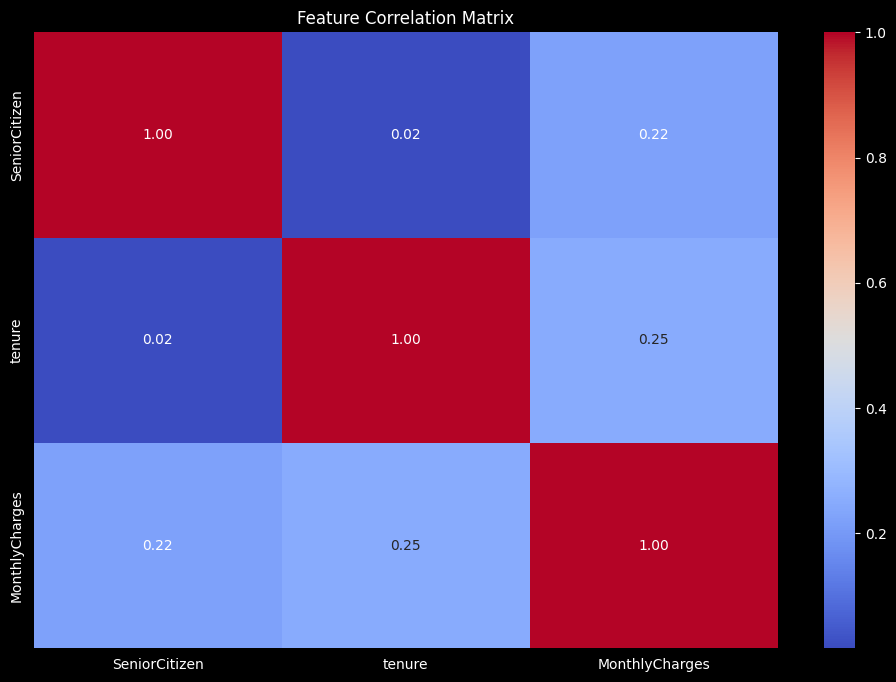

In [17]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    # Solo columnas numéricas
    corr = df.select_dtypes(include=['number']).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Matrix')
    plt.show()

plot_correlation_matrix(df)

# Data Pre-Processing
We are going to start whit data preprocessing, we are going to follow the nexts steps
- Outliers
- Handling Missing Data
- Encoding categorical variables
- Feature Scaling

In [8]:
def detect_outliers_iqr(df, column):
    # Primero visualizamos con un Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column} before cleaning')
    plt.show()

    # Cálculo matemático
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Columna {column}: Encontrados {len(outliers)} outliers.")
    return lower_bound, upper_bound

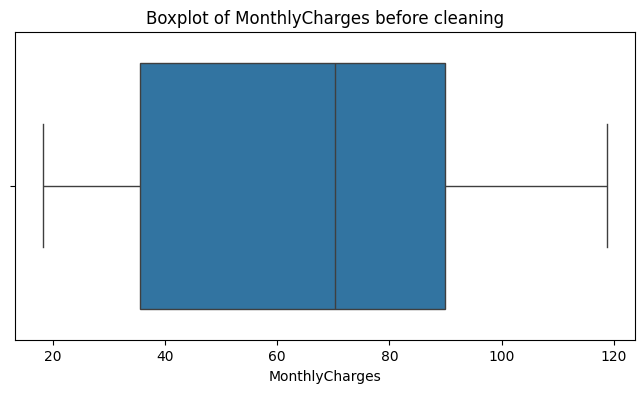

Columna MonthlyCharges: Encontrados 0 outliers.


(np.float64(-46.02499999999999), np.float64(171.375))

In [9]:
detect_outliers_iqr(df, 'MonthlyCharges')

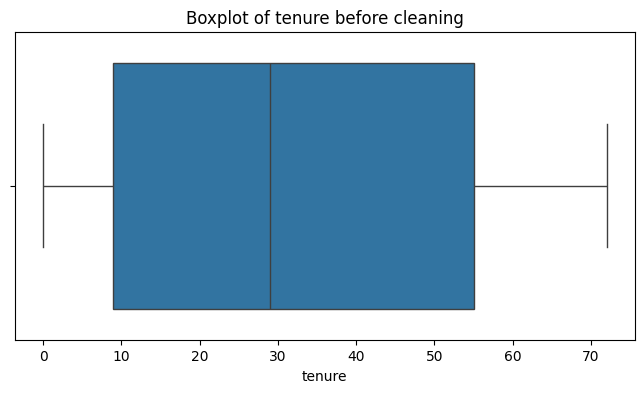

Columna tenure: Encontrados 0 outliers.


(np.float64(-60.0), np.float64(124.0))

In [10]:
detect_outliers_iqr(df, 'tenure')

There aren`t any outliers, but we already konw becaues we can see this in 'plot_price_evolution' graph

In [11]:
temp_total_charges = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"Nulos ocultos encontrados: {temp_total_charges.isna().sum()}")

Nulos ocultos encontrados: 11


In [12]:
# 1. Creamos una máscara para identificar los nulos invisibles
nulos_invisibles = pd.to_numeric(df['TotalCharges'], errors='coerce').isna()

# 2. Filtramos el DataFrame original para ver solo esas filas
analisis_nulos = df[nulos_invisibles][['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

print("Análisis de filas con cargos totales nulos:")
print(analisis_nulos)

# 3. Comprobación estadística
print("\nDistribución de Churn en los clientes con TotalCharges nulo:")
print(analisis_nulos['Churn'].value_counts())

Análisis de filas con cargos totales nulos:
      tenure  MonthlyCharges TotalCharges Churn
488        0           52.55                 No
753        0           20.25                 No
936        0           80.85                 No
1082       0           25.75                 No
1340       0           56.05                 No
3331       0           19.85                 No
3826       0           25.35                 No
4380       0           20.00                 No
5218       0           19.70                 No
6670       0           73.35                 No
6754       0           61.90                 No

Distribución de Churn en los clientes con TotalCharges nulo:
Churn
No    11
Name: count, dtype: int64


In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Rellenamos esos NaN con 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# 3. Verificación final: Comprobamos que ya no hay nulos y que el tipo es float
print(f"Nulos en TotalCharges tras la limpieza: {df['TotalCharges'].isnull().sum()}")
print(f"Tipo de dato de TotalCharges: {df['TotalCharges'].dtype}")

# 4. Comprobación de lógica: ¿Los que tienen 0 en TotalCharges son los de tenure 0?
check_new_customers = df[df['tenure'] == 0][['tenure', 'TotalCharges']]
print("\nVerificación de nuevos clientes (tenure 0):")
print(check_new_customers.head())

Nulos en TotalCharges tras la limpieza: 0
Tipo de dato de TotalCharges: float64

Verificación de nuevos clientes (tenure 0):
      tenure  TotalCharges
488        0           0.0
753        0           0.0
936        0           0.0
1082       0           0.0
1340       0           0.0


Lets continue with Encoding categorical variables, we have two cases
- Label Encoding for categories that have an implicit order
- One-Hot Encoding (Dummies)

In [14]:
#We are going to remove also the first column whit ID because it only introduces noise
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
    print("Columna 'customerID' eliminada.")

#Label Encoding
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    if col == 'gender':
        df[col] = df[col].map({'Female': 1, 'Male': 0})
    else:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# One-Hot Encoding
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaymentMethod']

df_final = pd.get_dummies(df, columns=multi_cols, drop_first=True)
print(f"One-Hot Encoding completado. Columnas finales: {len(df_final.columns)}")

Columna 'customerID' eliminada.
One-Hot Encoding completado. Columnas finales: 31


In [16]:
print(df_final.info()) #Mirar que columnas son objetos (texto) y cuáles números
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult